In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [932]:
# Load packages
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
import pickle

In [933]:
FILE_PATH = '../data/raw/survey_results_public.csv'
LOAD_PATH = '../data/interim/'
LOAD_SKILLS_DEV = '4.1-preprocessed-data_skills_dev.pkl'
LOAD_HEAT_MAP = '5.0-EDA-heat_map.pkl'
SAVE_SKILLS_DEV = '6.0-Engineered_data-split_roles.pkl'
SAVE_CLUSTERED_skills  =  '6.0-clustered_skills.pkl'

## Helper Function

In [4]:
def reduce_dimensions(df):
    """Apply Tsne on the data frame for visualization & clustering purposes"""

    tsne_data = pd.DataFrame(TSNE(n_components=2, learning_rate=.01,
                                 perplexity=3, n_iter = 10**10).fit_transform(df),
                 index = df.index)

    return tsne_data

In [863]:
def evaluate_cluster_model(tsne_data, range_clusters=range(1,5), plot = True):
    """using silhouette_score to chose the best number of clusters to cluster with using Kmeans clusters

    @param tsne_data: Dataframe result of TSNE algorithm
    @param range_clusters: The range of clusters you need to chose between them
    @param plot: Specify wither you need to plot silhouette_score values with clusters range and also plot Elbow Method or not

    @return: the best cluster number, and results of clustering
    """

    scores = []
    wcss = []
    for k in range_clusters:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init='auto', random_state=0)
        labels = kmeans.fit_predict(tsne_data)
        wcss.append(kmeans.inertia_)


        score = silhouette_score(tsne_data, labels)
        scores.append(score)


    best_k = np.argmax(scores) + range_clusters[0]
    best_labels = KMeans(n_clusters=best_k, init='k-means++', max_iter=1000, n_init='auto', random_state=0).fit_predict(tsne_data)
    best_labels = np.array([f'cluster_{label}' for label in best_labels])

    if plot:
        # silhouette score
        fig = px.line(x= range_clusters, y = scores)
        fig.add_vline(best_k)
        fig.update_layout(height=450, width=900, title='Silhouette Score')
        fig.show()


        # Plot the WCSS values
        plt.plot(range_clusters, wcss)
        plt.title('Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()

    return best_k, best_labels

In [228]:
def visualize_chosen_cluster_model(role_type, tsne_data, cluster_labels):
    fig = px.scatter(x=tsne_data[0],
                    y=tsne_data[1],
                    text=tsne_data.index,
                    color=cluster_labels,
                     color_discrete_sequence=px.colors.qualitative.Dark24)
    fig.update_traces(textposition='top center')
    fig.update_layout(height=900, width=1500, title_text=f'Clustering top skills for {role_type}')
    fig.show()

# More preprocessing steps:
### 1. Drop roles: ['Student', 'Other (please specify):', 'Designer', 'Educator', 'Product manager', 'Marketing or sales professional']
### 2. split roles: ['Developer_full-stack', 'Developer_back-end']
### 3. Cluster similar roles

# Load Data

In [919]:
skills_dev_df = pd.read_pickle(LOAD_PATH + LOAD_SKILLS_DEV)
developers_skills = pd.read_pickle(LOAD_PATH + LOAD_HEAT_MAP)

# 1. Drop roles: ['Student', 'Other (please specify):', 'Designer', 'Educator', 'Product manager', 'Marketing or sales professional']

In [922]:
drop_roles = ['Student',
              'Other (please specify):',
              'Designer',
              'Educator',
              'Product manager',
              'Marketing or sales professional']

In [923]:
skills_dev_df = skills_dev_df.drop(drop_roles, axis = 1, level=1)

In [924]:
developers_skills = developers_skills.drop(drop_roles)

# 2. split roles: ['Developer_full-stack', 'Developer_back-end']

In [235]:
split_roles = ['Developer_full-stack', 'Developer_back-end']

In [446]:
def choose_most_related_skills(roles_type:list=None, exclude_roles:list = None, threshold:float = .5) ->pd.DataFrame:
    """For splitting roles we need to choose the most related skills with this role to cluster them and by using this we can split roles successfully

    @param roles_type: roles you need to choose the most related skills for them
    @param exclude_roles: roles you need to exclude to make sure that, skills results are related with our roles types not any other roles
    @param threshold: specify thresholding --percent from the mean of skills-- of sorted skills, choose only skills that have value more than the percent of skills mean

    @return: Most related skills for specific roles"""
    if roles_type is None:
        roles_type = ['Developer_full-stack']

    # Create mask for chosen roles
    role_mask = skills_dev_df['DevType'][roles_type].sum(axis = 1) == len(roles_type)
    if exclude_roles:
        role_mask =  role_mask & (skills_dev_df['DevType'][exclude_roles].sum(axis = 1) == 0)

    # applying mask on skills_dev_df and calculate the mean of these skills
    role_skills = skills_dev_df.loc[role_mask,: ].drop('DevType', axis = 1, level = 0).droplevel(axis =1, level = 0).mean() * 100
    # sorting skills
    most_related_role_skills = role_skills.sort_values(ascending=False)
    # choosing the most related skills, skills that have values higher than percent --threshold-- from the mean of all skills
    most_related_role_skills = most_related_role_skills[most_related_role_skills> threshold * most_related_role_skills.mean()].index

    # Choose these skills from the masking dataframe and return them
    role_skills = skills_dev_df.loc[role_mask,: ].drop('DevType', axis = 1, level = 0).droplevel(axis = 1, level = 0)
    role_skills = role_skills.T
    role_skills = role_skills.loc[most_related_role_skills,:]

    return  role_skills

## A) Developer_full-stack

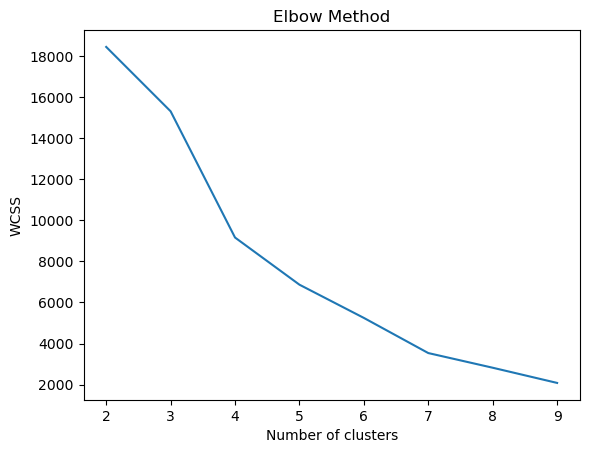

In [548]:
full_stack_skills = choose_most_related_skills(roles_type = [split_roles[0]])
full_stack_tsne = reduce_dimensions(full_stack_skills)
best_k, best_labels_full_stack = evaluate_cluster_model(full_stack_tsne, range_clusters=range(2,10), plot = True)
visualize_chosen_cluster_model(split_roles[0], full_stack_tsne, best_labels_full_stack)

In [790]:
for label in sorted(set(best_labels_full_stack)):
    print(label, list(full_stack_tsne[best_labels_full_stack==label].index))


cluster_0 ['Bash/Shell', 'MongoDB', 'Google Cloud', 'Sublime Text', 'Android Studio', 'DigitalOcean', 'Rust', 'Firebase', 'DynamoDB', 'Webstorm', 'React Native', 'Xcode', 'Ansible', 'Flutter', 'Rider', 'Svelte', 'Nano', 'Electron']
cluster_1 ['Homebrew', 'Heroku', 'Ruby', 'Ruby on Rails']
cluster_2 ['C#', 'Visual Studio', 'Microsoft SQL Server', '.NET', 'Microsoft Azure', 'ASP.NET Core ']
cluster_3 ['JavaScript', 'Visual Studio Code', 'HTML/CSS', 'npm', 'SQL', 'TypeScript', 'React.js', 'Node.js', 'Yarn', 'Express', 'Next.js']
cluster_4 ['Notepad++', 'Angular', 'jQuery', 'ASP.NET', 'PowerShell', 'Oracle', 'Eclipse', 'Angular.js', 'Blazor']
cluster_5 ['Python', 'SQLite', 'Vim', 'C++', 'PyCharm', 'NumPy', 'Pandas', 'Django', 'C', 'Flask']
cluster_6 ['MySQL', 'Vue.js', 'PHP', 'MariaDB', 'Laravel', 'PhpStorm']
cluster_7 ['Docker', 'AWS', 'PostgreSQL', 'Redis', 'Kubernetes', 'Elasticsearch', 'Go', 'Terraform', 'Apache Kafka', 'Kotlin']
cluster_8 ['Java', 'IntelliJ', 'Spring']


In [791]:
# filtering skills results
full_stack_roles_skills = []
for label in sorted(set(best_labels_full_stack)):
    # these clusters numbers are not specific for any full_stack developer, but it's general skills
    if label in  [f'cluster_{i}' for i in [0, 4, 7]]:
        continue

    cluster_labels = list(full_stack_tsne[best_labels_full_stack==label].index)
    if label == 'cluster_3':
        # full stack developers--all types-- must have these skills
        [cluster_labels.remove(item) for item in  ['JavaScript', 'Visual Studio Code', 'HTML/CSS', 'npm', 'SQL', 'TypeScript']]

    elif label== 'cluster_5':
        # these skills ['C', 'C++', 'Vim'] Somewhat far from other skills
        [cluster_labels.remove(item) for item in  ['C', 'C++', 'Vim']]

    full_stack_roles_skills.append(cluster_labels )
full_stack_roles_skills

[['Homebrew', 'Heroku', 'Ruby', 'Ruby on Rails'],
 ['C#',
  'Visual Studio',
  'Microsoft SQL Server',
  '.NET',
  'Microsoft Azure',
  'ASP.NET Core '],
 ['React.js', 'Node.js', 'Yarn', 'Express', 'Next.js'],
 ['Python', 'SQLite', 'PyCharm', 'NumPy', 'Pandas', 'Django', 'Flask'],
 ['MySQL', 'Vue.js', 'PHP', 'MariaDB', 'Laravel', 'PhpStorm'],
 ['Java', 'IntelliJ', 'Spring']]

In [792]:
full_stack_types = [ 'full_stack_Ruby-on-Rails', 'full_stack_.NET', 'full_stack_.JavaScript', 'full_stack_python',  'full_stack_PHP', 'full_stack_Java']

In [793]:
is_full_stack = skills_dev_df['DevType']['Developer_full-stack'] == 1
print(is_full_stack.sum())
full_stack_roles = {}
for i, cluster_labels in enumerate(full_stack_roles_skills):

    total_skills = skills_dev_df.droplevel(level=0, axis = 1)[cluster_labels].sum(axis=1)

    # assign true for this specific type if this developer has summation skills more than the mean
    is_full_stack_specific_type = total_skills > total_skills.mean()
    print(f'cluster_{i}: ', (is_full_stack & is_full_stack_specific_type).sum())
    full_stack_roles[full_stack_types[i]] = is_full_stack & is_full_stack_specific_type

20928
cluster_0:  6003
cluster_1:  6341
cluster_2:  9696
cluster_3:  5567
cluster_4:  7950
cluster_5:  5481


## Good results

In [794]:
full_stack_roles_df = pd.concat(full_stack_roles, axis = 1)
full_stack_roles_df = pd.concat([full_stack_roles_df,is_full_stack], axis = 1)
full_stack_roles_df


,full_stack_Ruby-on-Rails,full_stack_.NET,full_stack_.JavaScript,full_stack_python,full_stack_PHP,full_stack_Java,Developer_full-stack
2,False,False,False,False,False,False,False
3,False,True,False,False,False,False,True
7,False,False,False,False,False,False,True
9,False,False,False,False,False,False,False
10,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...
73262,False,False,False,False,False,False,False
73263,False,False,False,False,False,False,False
73264,False,False,False,False,False,False,False
73265,False,True,True,True,True,False,True


In [795]:
# count number of roles that is full stack, but not have any specific type
(full_stack_roles_df.iloc[full_stack_roles_df['Developer_full-stack'].values,:-1].sum(axis=1) == 0).sum()

4142

In [796]:
full_stack_roles_df = full_stack_roles_df.rename(columns = {'Developer_full-stack': 'full-stack_general'})
full_stack_roles_df.columns = pd.MultiIndex.from_product([['DevType'], full_stack_roles_df.columns])
full_stack_roles_df = full_stack_roles_df.astype(int)
full_stack_roles_df

DevType                                         \
      full_stack_Ruby-on-Rails full_stack_.NET full_stack_.JavaScript   
2                            0               0                      0   
3                            0               1                      0   
7                            0               0                      0   
9                            0               0                      0   
10                           0               1                      0   
...                        ...             ...                    ...   
73262                        0               0                      0   
73263                        0               0                      0   
73264                        0               0                      0   
73265                        0               1                      1   
73266                        0               0                      0   

                                                                           
      full_stack_python full_stack_PHP full_stack_Java full-stack_general  
2                     0              0               0                  0  
3                     0              0               0                  1  
7                     0              0               0                  1  
9                     0              0               0                  0  
10                    0              0               0                  1  
...                 ...            ...             ...                ...  
73262                 0              0               0                  0  
73263                 0              0               0                  0  
73264                 0              0               0                  0  
73265                 1              1               0                  1  
73266                 0              0               0                  0  

[50423 rows x 7 columns]

--------------------------

## B) Developer_back-end
Repeat the same steps

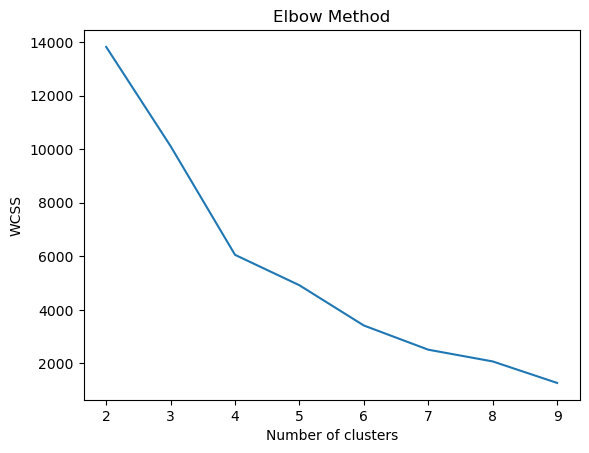

In [720]:
# Here we need to split back-end developer, by also excluding Front-end and mobile roles
back_end_skills = choose_most_related_skills(roles_type = [split_roles[1]], exclude_roles=['Developer_front-end', 'Developer_mobile'])
back_end_tsne = reduce_dimensions(back_end_skills)
best_k, best_labels_back_end = evaluate_cluster_model(back_end_tsne, range_clusters=range(2,10), plot = True)
visualize_chosen_cluster_model(split_roles[1], back_end_tsne, best_labels_back_end)

In [800]:
for label in sorted(set(best_labels_back_end)):
    print(label, list(back_end_tsne[best_labels_back_end==label].index))


cluster_0 ['MySQL', 'jQuery', 'MariaDB', 'PHP', 'PhpStorm']
cluster_1 ['AWS', 'PostgreSQL', 'Homebrew', 'Yarn', 'Ruby', 'Heroku', 'Ruby on Rails']
cluster_2 ['Bash/Shell', 'Vim', 'C++', 'Rust', 'C', 'Neovim']
cluster_3 ['Visual Studio Code', 'SQL', 'JavaScript', 'npm', 'HTML/CSS', 'TypeScript', 'Node.js', 'React.js', 'Express']
cluster_4 ['C#', 'Visual Studio', 'Notepad++', 'Microsoft Azure', 'Microsoft SQL Server', '.NET', 'ASP.NET Core ', 'ASP.NET']
cluster_5 ['MongoDB', 'Google Cloud', 'Sublime Text', 'Oracle', 'Ansible', 'Angular', 'Eclipse', 'PowerShell', 'Vue.js', 'DigitalOcean', 'IPython/Jupyter', 'Android Studio', 'Apache Spark', 'Rider', 'Cassandra', 'TensorFlow', 'Nano']
cluster_6 ['Python', 'SQLite', 'PyCharm', 'NumPy', 'Pandas', 'Flask', 'Django', 'FastAPI']
cluster_7 ['Docker', 'Kubernetes', 'Redis', 'Go', 'Elasticsearch', 'Apache Kafka', 'Terraform', 'DynamoDB', 'Kotlin', 'Emacs', 'Scala', 'GoLand', 'Groovy']
cluster_8 ['IntelliJ', 'Java', 'Spring']


In [801]:
# Filtering cluster results
back_end_roles_skills = []
for label in sorted(set(best_labels_back_end)):
    # these clusters numbers are not specific for any full_stack developer, but it's general skills
    if label in  [f'cluster_{i}' for i in [5, 7]]:
        continue
    cluster_labels = list(back_end_tsne[best_labels_back_end==label].index)
    if label == 'cluster_3':
        [cluster_labels.remove(item) for item in  ['JavaScript', 'Visual Studio Code', 'HTML/CSS', 'npm', 'SQL', 'TypeScript']]


    back_end_roles_skills.append(cluster_labels)
back_end_roles_skills

[['MySQL', 'jQuery', 'MariaDB', 'PHP', 'PhpStorm'],
 ['AWS', 'PostgreSQL', 'Homebrew', 'Yarn', 'Ruby', 'Heroku', 'Ruby on Rails'],
 ['Bash/Shell', 'Vim', 'C++', 'Rust', 'C', 'Neovim'],
 ['Node.js', 'React.js', 'Express'],
 ['C#',
  'Visual Studio',
  'Notepad++',
  'Microsoft Azure',
  'Microsoft SQL Server',
  '.NET',
  'ASP.NET Core ',
  'ASP.NET'],
 ['Python',
  'SQLite',
  'PyCharm',
  'NumPy',
  'Pandas',
  'Flask',
  'Django',
  'FastAPI'],
 ['IntelliJ', 'Java', 'Spring']]

In [804]:
back_end_types = ['back_end_PHP', 'back_end_Ruby-on-Rails', 'back_end_C++', 'back_end_.JavaScript', 'back_end_.NET', 'back_end_python', 'back_end_Java']

In [808]:
is_back_end = skills_dev_df['DevType']['Developer_back-end'] == 1
print(is_back_end.sum())
back_end_roles = {}
for i, cluster_labels in enumerate(back_end_roles_skills):

    total_skills = skills_dev_df.droplevel(level=0, axis = 1)[cluster_labels].sum(axis=1)
    is_back_end_specific_type = total_skills > total_skills.mean()
    print(f'cluster_{i}: ', (is_back_end & is_back_end_specific_type).sum())
    back_end_roles[back_end_types[i]] = is_back_end & is_back_end_specific_type

18692
cluster_0:  6669
cluster_1:  7846
cluster_2:  6368
cluster_3:  5981
cluster_4:  5425
cluster_5:  6254
cluster_6:  6291


In [809]:
back_end_roles_df = pd.concat(back_end_roles, axis = 1)
back_end_roles_df = pd.concat([back_end_roles_df,is_back_end], axis = 1)
back_end_roles_df


,back_end_PHP,back_end_Ruby-on-Rails,back_end_C++,back_end_.JavaScript,back_end_.NET,back_end_python,back_end_Java,Developer_back-end
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False
10,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...
73262,False,False,False,False,False,False,False,False
73263,True,True,True,True,False,True,False,True
73264,False,False,False,False,False,False,False,False
73265,False,False,False,False,False,False,False,False


In [810]:
(back_end_roles_df.iloc[back_end_roles_df['Developer_back-end'].values,:-1].sum(axis=1) ==0).sum()

3177

In [811]:
back_end_roles_df = back_end_roles_df.rename(columns = {'Developer_back-end': 'back_end_general'})
back_end_roles_df.columns = pd.MultiIndex.from_product([['DevType'], back_end_roles_df.columns])
back_end_roles_df = back_end_roles_df.astype(int)
back_end_roles_df

DevType                                                           \
      back_end_PHP back_end_Ruby-on-Rails back_end_C++ back_end_.JavaScript   
2                0                      0            0                    0   
3                0                      0            0                    0   
7                0                      0            0                    0   
9                0                      0            0                    0   
10               0                      0            0                    0   
...            ...                    ...          ...                  ...   
73262            0                      0            0                    0   
73263            1                      1            1                    1   
73264            0                      0            0                    0   
73265            0                      0            0                    0   
73266            0                      0            0                    0   

                                                                    
      back_end_.NET back_end_python back_end_Java back_end_general  
2                 0               0             0                0  
3                 0               0             0                0  
7                 0               0             0                0  
9                 0               0             0                0  
10                1               0             0                1  
...             ...             ...           ...              ...  
73262             0               0             0                0  
73263             0               1             0                1  
73264             0               0             0                0  
73265             0               0             0                0  
73266             0               0             0                0  

[50423 rows x 8 columns]

---------------------

# 3. Clustering similar skills

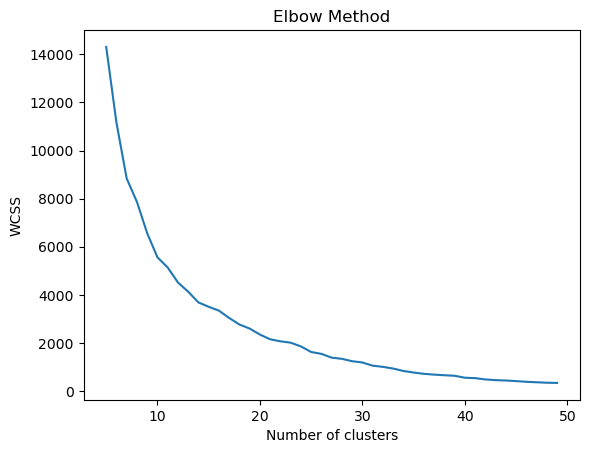

In [872]:
all_skills = skills_dev_df.drop('DevType', axis = 1, level = 0).droplevel(axis = 1, level = 0).T
all_skills_tsne = reduce_dimensions(all_skills)
best_k, best_labels_all_skills = evaluate_cluster_model(all_skills_tsne, range_clusters=range(5,50), plot = True)
visualize_chosen_cluster_model('All roles', all_skills_tsne, best_labels_all_skills)

In [874]:
for label in sorted(set(best_labels_all_skills)):
    print(label, list(all_skills_tsne[best_labels_all_skills==label].index))

cluster_0 ['Cassandra', 'Elasticsearch', 'PostgreSQL', 'Redis', 'Apache Kafka']
cluster_1 ['APL', 'Colocation', 'Linode', 'Managed Hosting', 'CLion', 'TextMate']
cluster_10 ['Oracle', 'Oracle Cloud Infrastructure']
cluster_11 ['FastAPI', 'Flask', 'PyCharm']
cluster_12 ['Scala', 'Play Framework']
cluster_13 ['Go', 'GoLand']
cluster_14 ['IBM Cloud or Watson', 'GTK', 'Nano']
cluster_15 ['Delphi', 'RAD Studio (Delphi_C++ Builder)']
cluster_16 ['Cloud Firestore', 'Firebase Realtime Database', 'Firebase', 'Google Cloud']
cluster_17 ['R', 'Tidyverse', 'RStudio']
cluster_18 ['C#', 'SQL', 'Microsoft SQL Server', 'Microsoft Azure', 'ASP.NET Core ', '.NET', 'Visual Studio']
cluster_19 ['Hugging Face Transformers', 'Keras', 'Scikit-learn', 'TensorFlow', 'Torch/PyTorch', 'IPython/Jupyter']
cluster_2 ['MariaDB', 'Drupal', 'jQuery']
cluster_20 ['Capacitor', 'Cordova', 'Ionic']
cluster_21 ['Ansible', 'Chef', 'Pulumi', 'Terraform']
cluster_22 ['Elixir', 'Phoenix', 'Homebrew']
cluster_23 ['Objective-C',

### Adding new Features --clustering results--

In [887]:
skills_df = skills_dev_df.drop('DevType', axis=1, level = 0).droplevel(axis=1, level = 0)
clustered_skills_df = {}
for label in sorted(set(best_labels_all_skills)):
    clustered_skills = list(all_skills_tsne[best_labels_all_skills==label].index)
    clustered_skills_df[label] = skills_df[clustered_skills].sum(axis = 1)

In [888]:
clustered_skills_df = pd.concat(clustered_skills_df, axis = 1)
clustered_skills_df

,cluster_0,cluster_1,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,...,cluster_42,cluster_43,cluster_44,cluster_45,cluster_46,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.104301,0.0,0.000000,0.000000,0.0,0.104301,0.026075,0.078225,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.348833,0.000000,0.000000,0.000000
7,0.002722,0.008167,0.000000,0.000000,0.0,0.002722,0.0,0.000000,0.008167,0.0,...,0.005444,0.0,0.002722,0.005444,0.0,0.002722,0.013611,0.010889,0.008167,0.002722
9,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.337235,0.168618,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.168618
10,0.000000,0.000000,0.000000,0.000000,0.0,0.037356,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.112069,0.0,0.000000,0.074712,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73262,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.006500,0.007583,0.000000,0.001083
73263,0.425124,0.000000,0.000000,0.159422,0.0,0.053141,0.0,0.000000,0.159422,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.159422,0.637686,0.000000,0.159422,0.212562
73264,0.052150,0.000000,0.034767,0.086917,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.156451,0.000000,0.000000,0.000000,0.000000
73265,0.257735,0.343647,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.085912,0.0,...,0.000000,0.0,0.085912,0.000000,0.0,0.515471,0.257735,0.000000,0.257735,0.000000


In [889]:
clustered_skills_df.columns = pd.MultiIndex.from_product([['clustered_skills'], clustered_skills_df.columns])

In [909]:
clustered_skills_df

clustered_skills                                                        \
             cluster_0 cluster_1 cluster_10 cluster_11 cluster_12 cluster_13   
2             0.000000  0.000000   0.000000   0.000000        0.0   0.000000   
3             0.000000  0.000000   0.000000   0.000000        0.0   0.000000   
7             0.002722  0.008167   0.000000   0.000000        0.0   0.002722   
9             0.000000  0.000000   0.000000   0.000000        0.0   0.000000   
10            0.000000  0.000000   0.000000   0.000000        0.0   0.037356   
...                ...       ...        ...        ...        ...        ...   
73262         0.000000  0.000000   0.000000   0.000000        0.0   0.000000   
73263         0.425124  0.000000   0.000000   0.159422        0.0   0.053141   
73264         0.052150  0.000000   0.034767   0.086917        0.0   0.000000   
73265         0.257735  0.343647   0.000000   0.000000        0.0   0.000000   
73266         0.000000  0.000000   0.271340   0.000000        0.0   0.000000   

                                                   ...                        \
      cluster_14 cluster_15 cluster_16 cluster_17  ... cluster_42 cluster_43   
2            0.0   0.000000   0.000000        0.0  ...   0.104301        0.0   
3            0.0   0.000000   0.000000        0.0  ...   0.000000        0.0   
7            0.0   0.000000   0.008167        0.0  ...   0.005444        0.0   
9            0.0   0.337235   0.168618        0.0  ...   0.000000        0.0   
10           0.0   0.000000   0.000000        0.0  ...   0.000000        0.0   
...          ...        ...        ...        ...  ...        ...        ...   
73262        0.0   0.000000   0.000000        0.0  ...   0.000000        0.0   
73263        0.0   0.000000   0.159422        0.0  ...   0.000000        0.0   
73264        0.0   0.000000   0.000000        0.0  ...   0.000000        0.0   
73265        0.0   0.000000   0.085912        0.0  ...   0.000000        0.0   
73266        0.0   0.814020   0.000000        0.0  ...   0.000000        0.0   

                                                                      \
      cluster_44 cluster_45 cluster_46 cluster_5 cluster_6 cluster_7   
2       0.000000   0.000000        0.0  0.104301  0.026075  0.078225   
3       0.000000   0.000000        0.0  0.000000  0.348833  0.000000   
7       0.002722   0.005444        0.0  0.002722  0.013611  0.010889   
9       0.000000   0.000000        0.0  0.000000  0.000000  0.000000   
10      0.000000   0.112069        0.0  0.000000  0.074712  0.000000   
...          ...        ...        ...       ...       ...       ...   
73262   0.000000   0.000000        0.0  0.000000  0.006500  0.007583   
73263   0.000000   0.000000        0.0  0.159422  0.637686  0.000000   
73264   0.000000   0.000000        0.0  0.156451  0.000000  0.000000   
73265   0.085912   0.000000        0.0  0.515471  0.257735  0.000000   
73266   0.000000   0.000000        0.0  0.000000  0.000000  0.000000   

                           
      cluster_8 cluster_9  
2      0.000000  0.000000  
3      0.000000  0.000000  
7      0.008167  0.002722  
9      0.000000  0.168618  
10     0.000000  0.000000  
...         ...       ...  
73262  0.000000  0.001083  
73263  0.159422  0.212562  
73264  0.000000  0.000000  
73265  0.257735  0.000000  
73266  0.000000  0.000000  

[50423 rows x 47 columns]

-----------------------------

# Concat all results

In [925]:
skills_dev_df = skills_dev_df.merge(full_stack_roles_df, left_index=True, right_index=True)
skills_dev_df = skills_dev_df.merge(back_end_roles_df, left_index=True, right_index=True)
skills_dev_df = skills_dev_df.drop(['back_end_general', 'full-stack_general'], axis=1, level = 1)
skills_dev_df

Languages                                                           \
            APL  Assembly Bash/Shell         C        C#       C++ COBOL   
2      0.000000  0.000000   0.000000  0.000000  0.078225  0.078225   0.0   
3      0.000000  0.000000   0.000000  0.000000  0.348833  0.000000   0.0   
7      0.002722  0.000000   0.002722  0.005444  0.000000  0.005444   0.0   
9      0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   0.0   
10     0.000000  0.000000   0.074712  0.000000  0.112069  0.000000   0.0   
...         ...       ...        ...       ...       ...       ...   ...   
73262  0.000000  0.002167   0.000000  0.002167  0.000000  0.003250   0.0   
73263  0.000000  0.000000   0.159422  0.000000  0.000000  0.000000   0.0   
73264  0.000000  0.000000   0.034767  0.000000  0.000000  0.000000   0.0   
73265  0.000000  0.000000   0.000000  0.000000  0.085912  0.000000   0.0   
73266  0.000000  0.000000   0.000000  0.000000  0.271340  0.000000   0.0   

                                 ...           DevType                 \
      Clojure Crystal      Dart  ... full_stack_python full_stack_PHP   
2         0.0     0.0  0.000000  ...                 0              0   
3         0.0     0.0  0.000000  ...                 0              0   
7         0.0     0.0  0.000000  ...                 0              0   
9         0.0     0.0  0.000000  ...                 0              0   
10        0.0     0.0  0.000000  ...                 0              0   
...       ...     ...       ...  ...               ...            ...   
73262     0.0     0.0  0.000000  ...                 0              0   
73263     0.0     0.0  0.106281  ...                 0              0   
73264     0.0     0.0  0.000000  ...                 0              0   
73265     0.0     0.0  0.000000  ...                 1              1   
73266     0.0     0.0  0.000000  ...                 0              0   

                                                                        \
      full_stack_Java back_end_PHP back_end_Ruby-on-Rails back_end_C++   
2                   0            0                      0            0   
3                   0            0                      0            0   
7                   0            0                      0            0   
9                   0            0                      0            0   
10                  0            0                      0            0   
...               ...          ...                    ...          ...   
73262               0            0                      0            0   
73263               0            1                      1            1   
73264               0            0                      0            0   
73265               0            0                      0            0   
73266               0            0                      0            0   

                                                                        
      back_end_.JavaScript back_end_.NET back_end_python back_end_Java  
2                        0             0               0             0  
3                        0             0               0             0  
7                        0             0               0             0  
9                        0             0               0             0  
10                       0             1               0             0  
...                    ...           ...             ...           ...  
73262                    0             0               0             0  
73263                    1             0               1             0  
73264                    0             0               0             0  
73265                    0             0               0             0  
73266                    0             0               0             0  

[50423 rows x 197 columns]

In [926]:
roles_df = skills_dev_df['DevType']
roles_df.columns = pd.MultiIndex.from_product([['DevType'], roles_df.columns])
skills_df = skills_dev_df.drop('DevType', axis=1, level = 0).merge(clustered_skills_df, left_index=True, right_index=True)
skills_dev_df = skills_df.merge(roles_df, left_index=True, right_index=True)
skills_dev_df

Languages                                                           \
            APL  Assembly Bash/Shell         C        C#       C++ COBOL   
2      0.000000  0.000000   0.000000  0.000000  0.078225  0.078225   0.0   
3      0.000000  0.000000   0.000000  0.000000  0.348833  0.000000   0.0   
7      0.002722  0.000000   0.002722  0.005444  0.000000  0.005444   0.0   
9      0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   0.0   
10     0.000000  0.000000   0.074712  0.000000  0.112069  0.000000   0.0   
...         ...       ...        ...       ...       ...       ...   ...   
73262  0.000000  0.002167   0.000000  0.002167  0.000000  0.003250   0.0   
73263  0.000000  0.000000   0.159422  0.000000  0.000000  0.000000   0.0   
73264  0.000000  0.000000   0.034767  0.000000  0.000000  0.000000   0.0   
73265  0.000000  0.000000   0.000000  0.000000  0.085912  0.000000   0.0   
73266  0.000000  0.000000   0.000000  0.000000  0.271340  0.000000   0.0   

                                 ...           DevType                 \
      Clojure Crystal      Dart  ... full_stack_python full_stack_PHP   
2         0.0     0.0  0.000000  ...                 0              0   
3         0.0     0.0  0.000000  ...                 0              0   
7         0.0     0.0  0.000000  ...                 0              0   
9         0.0     0.0  0.000000  ...                 0              0   
10        0.0     0.0  0.000000  ...                 0              0   
...       ...     ...       ...  ...               ...            ...   
73262     0.0     0.0  0.000000  ...                 0              0   
73263     0.0     0.0  0.106281  ...                 0              0   
73264     0.0     0.0  0.000000  ...                 0              0   
73265     0.0     0.0  0.000000  ...                 1              1   
73266     0.0     0.0  0.000000  ...                 0              0   

                                                                        \
      full_stack_Java back_end_PHP back_end_Ruby-on-Rails back_end_C++   
2                   0            0                      0            0   
3                   0            0                      0            0   
7                   0            0                      0            0   
9                   0            0                      0            0   
10                  0            0                      0            0   
...               ...          ...                    ...          ...   
73262               0            0                      0            0   
73263               0            1                      1            1   
73264               0            0                      0            0   
73265               0            0                      0            0   
73266               0            0                      0            0   

                                                                        
      back_end_.JavaScript back_end_.NET back_end_python back_end_Java  
2                        0             0               0             0  
3                        0             0               0             0  
7                        0             0               0             0  
9                        0             0               0             0  
10                       0             1               0             0  
...                    ...           ...             ...           ...  
73262                    0             0               0             0  
73263                    1             0               1             0  
73264                    0             0               0             0  
73265                    0             0               0             0  
73266                    0             0               0             0  

[50423 rows x 244 columns]

-------------------

# Saving results

In [929]:
skills_clusters = {}
for label in sorted(set(best_labels_all_skills)):
    skills_clusters[label] = list(all_skills_tsne[best_labels_all_skills == label].index)

In [930]:
skills_clusters

{'cluster_0': ['Cassandra',
  'Elasticsearch',
  'PostgreSQL',
  'Redis',
  'Apache Kafka'],
 'cluster_1': ['APL',
  'Colocation',
  'Linode',
  'Managed Hosting',
  'CLion',
  'TextMate'],
 'cluster_10': ['Oracle', 'Oracle Cloud Infrastructure'],
 'cluster_11': ['FastAPI', 'Flask', 'PyCharm'],
 'cluster_12': ['Scala', 'Play Framework'],
 'cluster_13': ['Go', 'GoLand'],
 'cluster_14': ['IBM Cloud or Watson', 'GTK', 'Nano'],
 'cluster_15': ['Delphi', 'RAD Studio (Delphi_C++ Builder)'],
 'cluster_16': ['Cloud Firestore',
  'Firebase Realtime Database',
  'Firebase',
  'Google Cloud'],
 'cluster_17': ['R', 'Tidyverse', 'RStudio'],
 'cluster_18': ['C#',
  'SQL',
  'Microsoft SQL Server',
  'Microsoft Azure',
  'ASP.NET Core ',
  '.NET',
  'Visual Studio'],
 'cluster_19': ['Hugging Face Transformers',
  'Keras',
  'Scikit-learn',
  'TensorFlow',
  'Torch/PyTorch',
  'IPython/Jupyter'],
 'cluster_2': ['MariaDB', 'Drupal', 'jQuery'],
 'cluster_20': ['Capacitor', 'Cordova', 'Ionic'],
 'cluster

In [934]:
with open(LOAD_PATH + SAVE_CLUSTERED_skills, 'wb') as f:
    pickle.dump(skills_clusters, f)

In [935]:
skills_dev_df.to_pickle(LOAD_PATH + SAVE_SKILLS_DEV)